In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score

import keras
from tensorflow.keras import layers, models
from keras.models import Sequential, Model,load_model
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPooling2D,MaxPool2D,AveragePooling2D,GlobalMaxPooling2D
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical
from keras import regularizers
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint
from keras.metrics import PrecisionAtRecall,Recall 

import os
import cv2
import random

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

import tensorflow as tf

SyntaxError: trailing comma not allowed without surrounding parentheses (2371658399.py, line 9)

In [73]:

path = r"C:\Users\Ethan\LUNG DISEASE CAPSTONE\COVID-19_Radiography_Dataset"
data_dir = os.path.join(path)
data = []
levels = ['NORMAL', 'COVID']
sublevels= ['images']
for id, level in enumerate(levels):
    for id, sublevel in enumerate(sublevels):
        for file in os.listdir(os.path.join(data_dir, level, sublevel)):
            data.append(['{}/{}'.format(level, file), level]) 


data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])

data['path'] = path + '/' + data['image_file']
data['corona_result'] = data['corona_result'].map({'NORMAL': 'Negative', 'COVID': 'Positive'})
samples = 13808

data

,image_file,corona_result,path
0,NORMAL/Normal-1.png,Negative,C:\Users\Ethan\LUNG DISEASE CAPSTONE\COVID-19_...
1,NORMAL/Normal-10.png,Negative,C:\Users\Ethan\LUNG DISEASE CAPSTONE\COVID-19_...
2,NORMAL/Normal-100.png,Negative,C:\Users\Ethan\LUNG DISEASE CAPSTONE\COVID-19_...
3,NORMAL/Normal-1000.png,Negative,C:\Users\Ethan\LUNG DISEASE CAPSTONE\COVID-19_...
4,NORMAL/Normal-10000.png,Negative,C:\Users\Ethan\LUNG DISEASE CAPSTONE\COVID-19_...
...,...,...,...
13803,COVID/COVID-995.png,Positive,C:\Users\Ethan\LUNG DISEASE CAPSTONE\COVID-19_...
13804,COVID/COVID-996.png,Positive,C:\Users\Ethan\LUNG DISEASE CAPSTONE\COVID-19_...
13805,COVID/COVID-997.png,Positive,C:\Users\Ethan\LUNG DISEASE CAPSTONE\COVID-19_...
13806,COVID/COVID-998.png,Positive,C:\Users\Ethan\LUNG DISEASE CAPSTONE\COVID-19_...


In [53]:
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

data.head()

,image_file,corona_result,path,image
0,NORMAL/Normal-1.png,Negative,C:\Users\Ethan\LUNG DISEASE CAPSTONE\COVID-19_...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,NORMAL/Normal-10.png,Negative,C:\Users\Ethan\LUNG DISEASE CAPSTONE\COVID-19_...,"[[9, 9, 9, 8, 8, 7, 6, 4, 3, 2, 1, 1, 1, 0, 0,..."
2,NORMAL/Normal-100.png,Negative,C:\Users\Ethan\LUNG DISEASE CAPSTONE\COVID-19_...,"[[0, 0, 0, 0, 12, 57, 75, 95, 111, 117, 119, 1..."
3,NORMAL/Normal-1000.png,Negative,C:\Users\Ethan\LUNG DISEASE CAPSTONE\COVID-19_...,"[[0, 6, 23, 51, 66, 69, 71, 67, 97, 96, 101, 1..."
4,NORMAL/Normal-10000.png,Negative,C:\Users\Ethan\LUNG DISEASE CAPSTONE\COVID-19_...,"[[136, 118, 106, 100, 96, 93, 91, 88, 87, 87, ..."


Text(0, 0.5, 'Count')

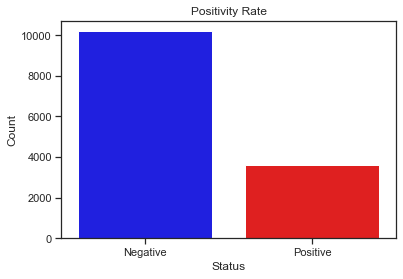

In [54]:
sns.countplot(data=data,x='corona_result' , palette=['blue','red']);
plt.title('Positivity Rate')
plt.xlabel('Status')
plt.ylabel('Count')

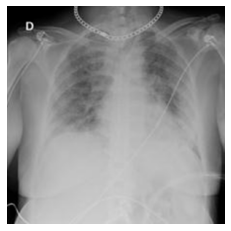

In [9]:
plt.figure()
image = cv2.imread(r"..\LUNG DISEASE CAPSTONE\COVID-19_Radiography_Dataset\COVID\images\COVID-1010.png")
plt.imshow(image)
plt.axis('off')
plt.show() 

In [10]:
print('Image Shape: {}'.format(image.shape))
print('Image Height: {}'.format(image.shape[0]))
print('Image Width: {}'.format(image.shape[1]))
print('Image Dimension: {}'.format(image.ndim))
print('Image Size: {}kb'.format(image.size//1024))
print('Image Data Type: {}'.format(image.dtype))
print('Maximum RGB value of the image: {}'.format(image.max()))
print('Minimum RGB value of the image: {}'.format(image.min()))

Image Shape: (299, 299, 3)
Image Height: 299
Image Width: 299
Image Dimension: 3
Image Size: 261kb
Image Data Type: uint8
Maximum RGB value of the image: 249
Minimum RGB value of the image: 0


In [55]:
all_covid = []
all_normal = []

all_normal.extend(glob(os.path.join(path, "Normal/images/*.png")))
all_covid.extend(glob(os.path.join(path, "COVID/images/*.png")))

random.shuffle(all_normal)
random.shuffle(all_covid)

images = all_normal + all_covid


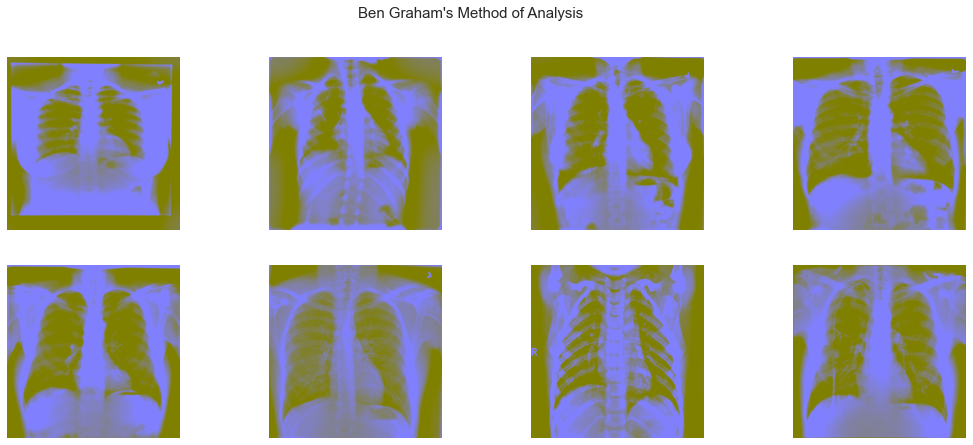

In [56]:
fig = plt.figure(figsize = (18, 7))
fig.suptitle("Ben Graham's Method of Analysis", fontsize = 15)
columns = 4; rows = 2

for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

This method has been used in several other medical image data sets where sometimes imgae quality suffers due to the nature of radiography and hospital conditions. The idea is to change the images to grayscale for ease of analysis, then coloration for ease of differentiation. This was pioneered by Benjamin Graham in a Diabetic Retinopathy dataset released under BSD.

In [57]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    
    fig, myaxes = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize = 15)
        
    plt.show()

In [58]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []

for i in range(0, samples):
    mean_val.append(data['image'][i].mean())
    std_dev_val.append(np.std(data['image'][i]))
    max_val.append(data['image'][i].max())
    min_val.append(data['image'][i].min())

imageEDA = data.loc[:,['image','corona_result','path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

imageEDA['subt_mean'] = imageEDA['mean'].mean() - imageEDA['mean']

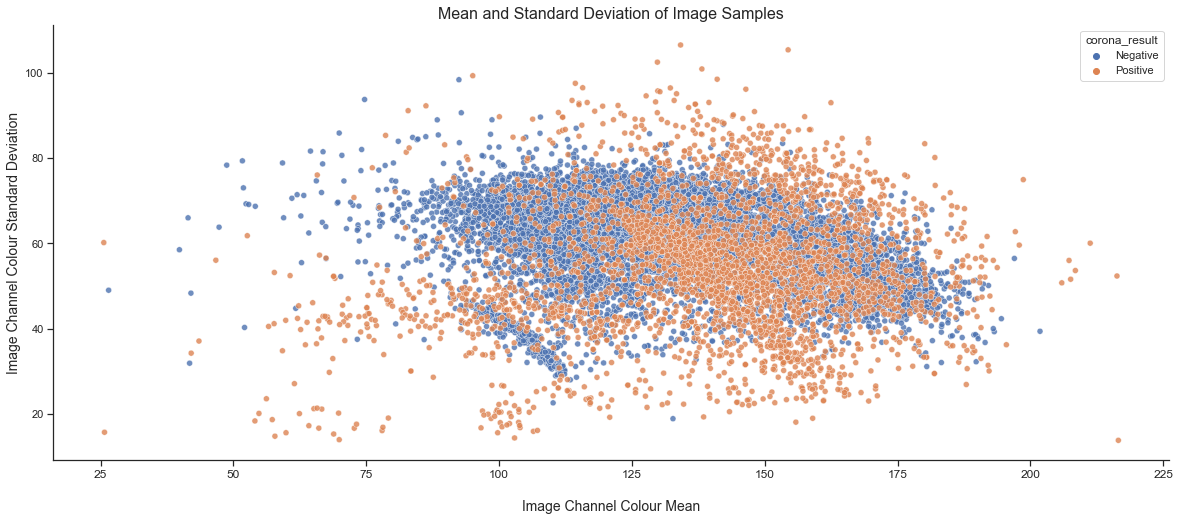

In [59]:
plt.figure(figsize = (20, 8))
sns.set(style = "ticks", font_scale = 1)
ax = sns.scatterplot(data = imageEDA, x = "mean", y = imageEDA['stedev'], hue = 'corona_result', alpha = 0.8);
sns.despine(top = True, right = True, left = False, bottom = False)
plt.xticks(rotation = 0, fontsize = 12)
ax.set_xlabel('\nImage Channel Colour Mean', fontsize = 14)
ax.set_ylabel('Image Channel Colour Standard Deviation', fontsize = 14)
plt.title('Mean and Standard Deviation of Image Samples', fontsize = 16);

<Figure size 720x576 with 0 Axes>

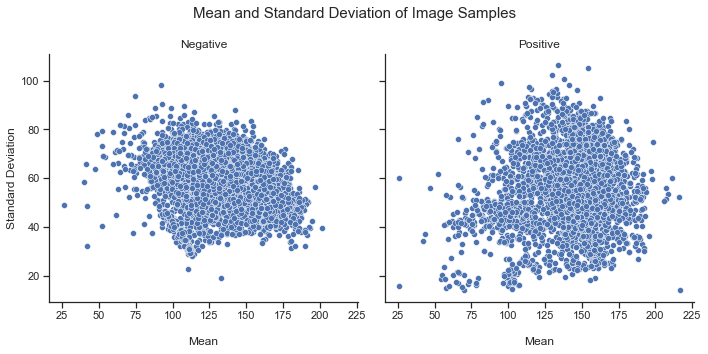

In [60]:
plt.figure(figsize = (10, 8));
g = sns.FacetGrid(imageEDA, col = "corona_result", height = 5);
g.map_dataframe(sns.scatterplot, x = 'mean', y = 'stedev');
g.set_titles(col_template = "{col_name}", row_template= "{row_name}", size = 12);
g.fig.subplots_adjust(top = .7);
g.fig.suptitle('Mean and Standard Deviation of Image Samples', fontsize = 15);
axes = g.axes.flatten();
axes[0].set_ylabel('Standard Deviation');
for ax in axes:
    ax.set_xlabel('\nMean');
g.fig.tight_layout();

In [61]:
all_data = []


for i in range(len(data)):
    image = cv2.imread(data['path'][i])
    image = cv2.resize(image, (70, 70)) / 255.0
    label = 1 if data['corona_result'][i] == "Positive" else 0
    all_data.append([image, label])

In [64]:
x = []
y = []

for image, label in all_data:
    x.append(image)
    y.append(label)

  
x = np.array(x)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

(9941, 70, 70, 3) (2762, 70, 70, 3) (1105, 70, 70, 3) (9941,) (2762,) (1105,)


In [67]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = (70, 70, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.3))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Dropout(0.5))

cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(units = 16, activation = 'relu'))
cnn_model.add(layers.Dropout(0.2))

cnn_model.add(layers.Dense(units = 2))

cnn_model.compile(optimizer = 'adam', 
           loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
           metrics = ['accuracy'])

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 68, 68, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 34, 34, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

In [70]:
tf.random.set_seed(42)


In [74]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)

history = cnn_model.fit(x_train, y_train, 
                        epochs = 50, batch_size = 256,  
                        validation_data = (x_val, y_val), 
                        callbacks = [es])

Epoch 1/50
39/39 [==============================] - 66s 2s/step - loss: 0.4511 - accuracy: 0.7770 - val_loss: 0.3855 - val_accuracy: 0.8226
Epoch 2/50
39/39 [==============================] - 71s 2s/step - loss: 0.3709 - accuracy: 0.8227 - val_loss: 0.3215 - val_accuracy: 0.8588
Epoch 3/50
39/39 [==============================] - 69s 2s/step - loss: 0.3357 - accuracy: 0.8451 - val_loss: 0.2959 - val_accuracy: 0.8805
Epoch 4/50
39/39 [==============================] - 69s 2s/step - loss: 0.2990 - accuracy: 0.8733 - val_loss: 0.2719 - val_accuracy: 0.8796
Epoch 5/50
39/39 [==============================] - 71s 2s/step - loss: 0.2797 - accuracy: 0.8779 - val_loss: 0.2478 - val_accuracy: 0.8887
Epoch 6/50
39/39 [==============================] - 70s 2s/step - loss: 0.2551 - accuracy: 0.8943 - val_loss: 0.2150 - val_accuracy: 0.9095
Epoch 7/50
39/39 [==============================] - 69s 2s/step - loss: 0.2412 - accuracy: 0.8998 - val_loss: 0.2260 - val_accuracy: 0.9005
Epoch 8/50
39/39 [==

In [75]:
yp_train = cnn_model.predict(x_train)
yp_train = np.argmax(yp_train, axis = 1)

yp_val = cnn_model.predict(x_val)
yp_val = np.argmax(yp_val, axis = 1)

yp_test = cnn_model.predict(x_test)
yp_test = np.argmax(yp_test, axis = 1)

87/87 [==============================] - 4s 45ms/step


In [79]:
def evaluation_parametrics(name, y_train, yp_train, y_val, yp_val, y_test, yp_test):
    
    print("\n-----------------------------{}-----------------------------\n".format(name))
    
    cm_train = confusion_matrix(y_train, yp_train)
    t1 = ConfusionMatrixDisplay(cm_train)
    s1 = round((cm_train[0,0]/(cm_train[0,0] + cm_train[0,1])),4)
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train, yp_train)) 
    print("--------------------------------------------------------------------------")
    print("Recall on Train Data: ", round(recall_score(y_train, yp_train),4))
    print("Specificity on Train Data: ", s1)
    print("Accuracy on Train Data: ", round(accuracy_score(y_train, yp_train),4))
    print("Precision on Train Data: ", round(precision_score(y_train, yp_train),4))
    print("F1 Score on Train Data: ", round(f1_score(y_train, yp_train),4))
    print("--------------------------------------------------------------------------")
       
    cm_val = confusion_matrix(y_val, yp_val)
    t2 = ConfusionMatrixDisplay(cm_val)
    s2 = round((cm_val[0,0]/(cm_val[0,0] + cm_val[0,1])),4)
    
    print("\nClassification Report for Validation Data\n")
    print(classification_report(y_val, yp_val))   
    print("--------------------------------------------------------------------------")
    print("Recall on Val Data: ", round(recall_score(y_val, yp_val),4))
    print("Specificity on Val Data: ", s2)
    print("Accuracy on Val Data: ", round(accuracy_score(y_val, yp_val),4))
    print("Precision on Val Data: ", round(precision_score(y_val, yp_val),4))
    print("F1 Score on Val Data: ", round(f1_score(y_val, yp_val),4))
    print("--------------------------------------------------------------------------")

    cm_test = confusion_matrix(y_test, yp_test)
    t3 = ConfusionMatrixDisplay(cm_test)
    s3 = round((cm_test[0,0]/(cm_test[0,0] + cm_test[0,1])),4)
    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))   
    print("--------------------------------------------------------------------------")
    print("Recall on Test Data: ", round(recall_score(y_test, yp_test), 4))
    print("Specificity on Test Data: ", s3)
    print("Accuracy on Test Data: ", round(accuracy_score(y_test, yp_test), 4))
    print("Precision on Test Data: ", round(precision_score(y_test, yp_test), 4))
    print("F1 Score Test Data: ", round(f1_score(y_test, yp_test), 4))
    print("--------------------------------------------------------------------------")
    
    t1.plot()
    t2.plot()   
    t3.plot()


-----------------------------Convolution Neural Network-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7287
           1       0.98      0.96      0.97      2654

    accuracy                           0.98      9941
   macro avg       0.98      0.98      0.98      9941
weighted avg       0.98      0.98      0.98      9941

--------------------------------------------------------------------------
Recall on Train Data:  0.9631
Specificity on Train Data:  0.9929
Accuracy on Train Data:  0.9849
Precision on Train Data:  0.9801
F1 Score on Train Data:  0.9715
--------------------------------------------------------------------------

Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       844
           1       0.94      0.90      0.92       261

    accuracy                

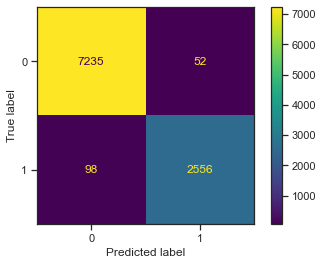

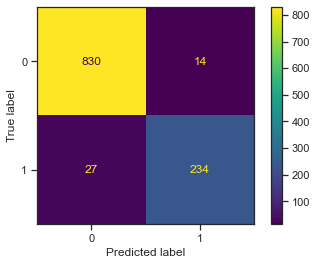

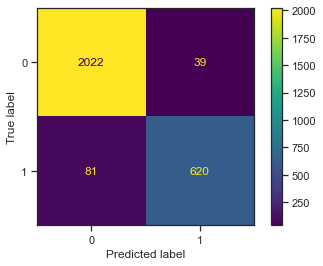

In [80]:
evaluation_parametrics("Convolution Neural Network", y_train, yp_train, y_val, yp_val, y_test, yp_test)

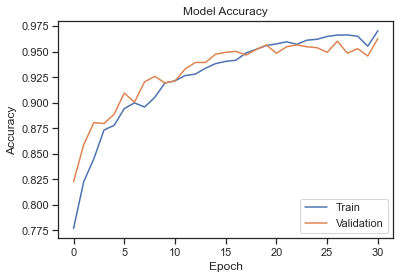

In [82]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

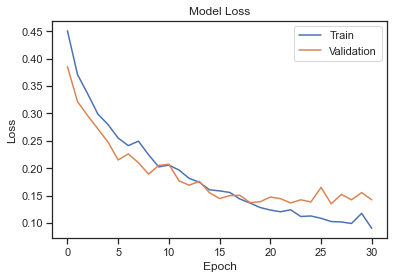

In [83]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

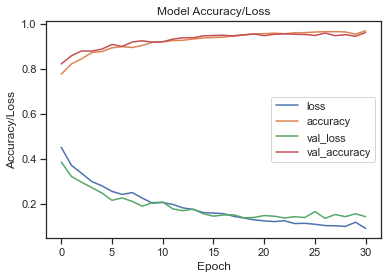

In [84]:
pd.DataFrame(history.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

In [85]:
cnn_model.save('cnn_model.h5')